# EDA into European Laptop Market

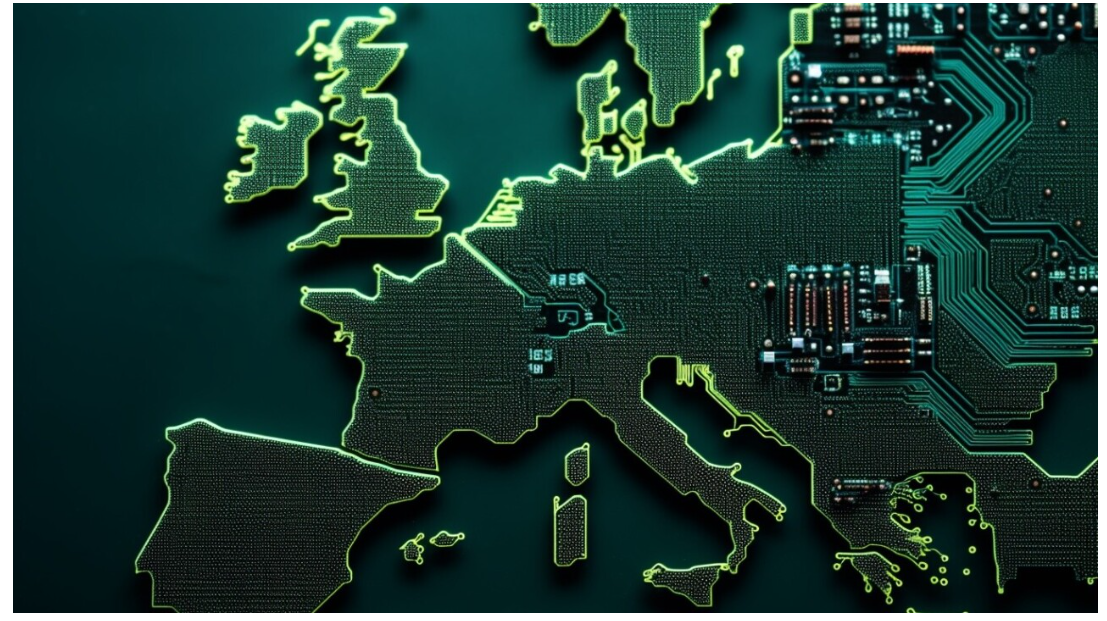

    -Source: https://thenextweb.com/news/state-open-source-europe

## First Imports, Loading Data, and Taking a Peak into our Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
warnings.filterwarnings('ignore')

In [ ]:
#source: https://www.kaggle.com/datasets/durgeshrao9993/laptop-specification-dataset
df = pd.read_csv('laptop_price (1).csv', encoding='latin-1')
df

In [ ]:
df.info()

## Data Cleaning Time

### Good News No NaN values, however there is other problems 
   
   - The data is does not have enough numerics to make a meanful statistical analysis 
   - A lot of the columns have useful data, but they need to parse to be used in a meaningful way

# !!! IMPORANT: If you have to run any cell for a second time in this section you must restart the kernal and run all !!!

#### Laptop ID is useless, let's drop it

In [ ]:
df.drop(['laptop_ID'], axis=1, inplace=True)

### Let's Get the Types of Cetrain Data
   - Cpu (Computer Processing Unit)-> The comapny that makes that laptop's CUP (GPU_TYPE)
   - Gpu (Graphic Processing Unit)-> The comapny that makes that laptop's GUP (GPU_TYPE)
   - Memory -> The type of storage a laptop uses

In [ ]:
df.insert(6,'CPU_TYPE', df['Cpu'].map(lambda x: x.split(' ')[0]))
df['CPU_TYPE'].unique()

In [ ]:
df.insert(10,'GPU_TYPE', df['Gpu'].map(lambda x: x.split(' ')[0]))
df['GPU_TYPE'].unique()

In [ ]:
df.insert(9,'Memory_TYPE', df['Memory'].map(lambda x: ' '.join(x.split(' ')[1:])))
df['Memory_TYPE'].unique()

### Too Many Types, Let's fix this
   - Any "+" types arejust Hybrids unless they are the same type + the same type then will be maped to that type: 
   - Ex:
   - SSD +  512GB SSD -> SSD
   - SSD +  2TB HDD -> HDD

In [ ]:
def parse_map(s):
    ref = s.split(' ')
    if '+' in ref:
        if ref[0] == ref[-1]: return ref[0]
        return 'Hybrid'
    return s
df['Memory_TYPE'] =  df['Memory_TYPE'].map(parse_map)
df['Memory_TYPE'].unique()

### Let's Make a CM column (Meteric system is Important to Europeans )

In [ ]:
df.insert(3,'CMs', df['Inches'].map(lambda x: round(x*2.54, 2)))
df['CMs']

### Let's Break down all the features in each laptop

In [ ]:
Screen_Extra_Specs = df['ScreenResolution'].map(lambda x: ' '.join(x.split(' ')[:-1]) if len(x.split(' ')) > 1 else 'None')
Screen_Extra_Specs.unique()

### Not Good enough, let's do better and put the features in a list 

In [ ]:
specs = ['IPS', 'Quad', 'Retina', 'Full', 'Touchscreen', 'Ultra']
Screen_Extra_Specs = Screen_Extra_Specs.map(lambda x: [spec for spec in x.split(' ') if spec in specs]).map(lambda x: x + ['None'] if len(x) < 1 else x)
Screen_Extra_Specs

In [ ]:
def spec_map(s):
    ref = {
        'IPS' : 'IPS Panel',
        'Quad' : 'Quad HD+',
        'Retina' : 'Retina Display',
        'Full' : 'Full HD',
        'Ultra' : '4K Ultra HD'
    }
    if s in ref.keys(): return ref[s]
    return s
specs = [spec_map(s) for s in specs]
Screen_Extra_Specs = Screen_Extra_Specs.map(lambda x: [spec_map(i) for i in x])
Screen_Extra_Specs

In [ ]:
df.insert(5,'Screen_Extra_Specs', Screen_Extra_Specs)
df['Screen_Extra_Specs']

### Let's keep a count of features 

In [ ]:
df.insert(6,'Specs_Count', Screen_Extra_Specs.map(lambda x: 0 if 'None' in x else len(x)))
df['Specs_Count']

### Let's parse and keep track of the pixels on each laptops

In [ ]:
df.insert(5,'Pixel_Dimensions', df['ScreenResolution'].map(lambda x: x.split(' ')[-1]))
df['Pixel_Dimensions'].unique()

In [ ]:
df.insert(5,'Pixel_Area', df['ScreenResolution'].map(lambda x: x.split(' ')[-1]).map(lambda x: int(x.split('x')[0]) * int(x.split('x')[1])))
df['Pixel_Area'].unique()

### Let's turn thoes string meteric to numerics

In [ ]:
df.insert(9, 'Clock_Speed(GHz)', df['Cpu'].map(lambda x: x.split(' ')[-1][:3]).map(lambda x: float(x) if x[1] == '.' else int(x[0])))
df['Clock_Speed(GHz)'].unique()

In [ ]:
df.rename(columns={'Ram' : 'RAM(GBs)'}, inplace=True)
df['RAM(GBs)'] = df['RAM(GBs)'].map(lambda x: int(x[:-2]))
df['RAM(GBs)'].unique()

### What is Kgs to American? Foreign, Let's add a a column in pounds

In [ ]:
df.rename(columns={'Weight' : 'Weight(kgs)'}, inplace=True)
df['Weight(kgs)'] = df['Weight(kgs)'].map(lambda x: float(x[:-2]))

In [ ]:
df.insert(17, 'Weight(lbs)', df['Weight(kgs)'].map(lambda x: round(x*2.20462,2)))
df[['Weight(lbs)', 'Weight(kgs)']]

### Anything in the OS column?

In [ ]:
df['OpSys'].value_counts()

### What is a computer with 'No OS'....? Cant be!
   -No OS means no Opertating system, no Opertating system mean no function, no function means I cant sell it
### We can just replace them with Windows 10, since most laptops have Windows 10 installed in this dataset.
   #### -Hold your horses,  Apple computers do not use windows 10, let's make sure no of these laptops are Apple laptops

In [ ]:
df[(df['OpSys'] == 'No OS')]['Company'].value_counts()

In [ ]:
df[(df['OpSys'] == 'Mac OS X') | (df['OpSys'] == 'macOS')]['Company'].value_counts()['Apple'] == df['Company'].value_counts()['Apple']

### Okay, no Apple computers without an OS, continue...

In [ ]:
df['OpSys'] = df['OpSys'].map(lambda x: 'Windows 10' if x == 'No OS' else x)
df['OpSys'].unique()

### These prices are out of date by a year... (currency wise), let's account for inflation

In [ ]:
df['Price_in_euros'] = df['Price_in_euros'].map(lambda x: round(x*1.01, 2))

### Europeans have a VAT -> Value Added Tax (about 21% on average), in American terms the sales tax is in the price. 
- Let's get the base value of the laptops

In [ ]:
df['Price_EUR_Before_VAT'] = df['Price_in_euros'].map(lambda x: round(x/1.21, 2))
df[['Price_EUR_Before_VAT', 'Price_in_euros']]

### Now that VAT is off we can the price as Americans can see it 

In [ ]:
df['Price_USD'] = df['Price_in_euros'].map(lambda x: round(x*1.09, 2))
df['Price_USD_Before_VAT'] = df['Price_EUR_Before_VAT'].map(lambda x: round(x*1.09, 2))

In [ ]:
df[['Price_in_euros', 'Price_USD','Price_USD_Before_VAT']]

### Ah the UK, the most influential contry in europe doesnt use Euros and has a different VAT in their prices

In [ ]:
df['Price_GBP'] = df['Price_EUR_Before_VAT'].map(lambda x: round(x*1.20, 2)).map(lambda x: round(x*.85, 2))

In [ ]:
df[['Price_in_euros', 'Price_GBP']]

## Data Clean is Done!
   - Let's rename some columns and get a review of the new and improved data set

In [ ]:
df.rename(columns={'Price_in_euros' : 'Price_EUR', 'Price_USD' : 'Price_USD_With_VAT', 'Price_USD_Before_VAT' : 'Price_USD'}, inplace=True)

In [ ]:
df

In [ ]:
df.info()

#### Since ScreenResolution can be put togeter and from Pixel_Dimensions and Screen_Extra_Specs it has no use, so let's drop like it's hot

In [ ]:
df.drop(['ScreenResolution'], axis=1, inplace=True) 

In [ ]:
df.info()

# Data Exploratory Analysis Part 1
 - For each major non-numeric column can we see which unique values that appear in a notible volume have:
     - A wide range of prices?
     - A narrowest range of prices?
     - Which has more expensive prices?
     - Which has more cheapest prices?
     - Do any distribution change with currencies?
     - Is Anything else notible?

In [ ]:
def describe(df): 
    df = df.describe()
    df['range'] = df['max'] - df['min']
    return df.applymap(lambda x: f"{x:0.2f}")

## Companies

In [ ]:
df['Company'].value_counts()

### Wow so many companies, but we are only going to focus on those that appear in a notible volume,  lets focus on ones that have 20 or more laptops in this dataset

### Show me thoes stats for each currency 

In [ ]:
gb_comp1 = df.groupby('Company').filter(lambda x: x['Product'].count() > 20)
price_per_comp = gb_comp1.groupby('Company')['Price_EUR']
describe(price_per_comp)

In [ ]:
price_per_comp = gb_comp1.groupby('Company')['Price_USD']
describe(price_per_comp)

In [ ]:
price_per_comp = gb_comp1.groupby('Company')['Price_GBP']
describe(price_per_comp)

### Okay, I can see the numbers, but let's *really* see the data with the distrubution

In [ ]:
x_axis = ['Price_EUR', 'Price_USD', 'Price_GBP']
fig, axes = plt.subplots(3, 8, figsize=(25, 10))
#https://stackoverflow.com/questions/45823078/how-to-sync-colors-across-subplots-of-different-types for palette = itertools.cycle(sns.color_palette())
for x in range(len(x_axis)):
    bins = range(int(df[x_axis[x]].min()), int(df[x_axis[x]].max()), int(df[x_axis[x]].median()) // 20)
    palette = itertools.cycle(sns.color_palette("husl", 9))
    for y in range(len(gb_comp1['Company'].unique())):
        comp_name = gb_comp1['Company'].unique()[y] 
        if x == 0: 
            sns.histplot(bins=bins, data=gb_comp1[gb_comp1['Company'] == comp_name], x=x_axis[x], ax=axes[x][y], color=next(palette)).set_title(f'Distrubtion of Prices for {comp_name}')
        else:  
            sns.histplot(bins=bins, data=gb_comp1[gb_comp1['Company'] == comp_name], x=x_axis[x], ax=axes[x][y], color=next(palette))
plt.subplots_adjust(hspace = .5, wspace=1.5)
plt.suptitle('Distrubtion of Prices by Brand')
plt.tight_layout()

## Companies Summary
   - The widest range of prices? 
       - Levono, it has the highest range stat and is the most apperent company in the modified data set.
   - The narrowest range of prices? 
       - Apple, it has the lowest range and is the least apperent company in the modified data set.
   - Which has most expensive prices?
       - From the graphs shown it seems to be Dell, the highest concentration of prices above $2000 that seems a bit spread out.
   - Which has most cheapest prices?
        - Acer, it has the lowest maximum and minimum.
   - Do any distribution change with currencies?
       - No the shape of graph is the same in each column the scale and labels are the only changes.
   - Is Anything else notible 
       - std of all companys are high perrty high

## GPU_TYPE

In [ ]:
df['GPU_TYPE'].value_counts()

### No Need to See ARM GUP_TYPE since there is only one

In [ ]:
gb_comp2 = df.groupby('GPU_TYPE').filter(lambda x: x['Product'].count() > 5)
price_per_gpu = gb_comp2.groupby('GPU_TYPE')['Price_EUR']
describe(price_per_gpu)

In [ ]:
price_per_gpu = gb_comp2.groupby('GPU_TYPE')['Price_USD']
describe(price_per_gpu)

In [ ]:
price_per_gpu = gb_comp2.groupby('GPU_TYPE')['Price_GBP']
describe(price_per_gpu)

### Okay, I can see the numbers, but let's **really** see the data with the distrubution

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for x in range(len(x_axis)):
    palette = itertools.cycle(sns.color_palette())
    bins = range(int(df[x_axis[x]].min()), int(df[x_axis[x]].max()), int(df[x_axis[x]].median()) // 20)
    for y in range(len(gb_comp2['GPU_TYPE'].unique())):
        gpu_type = gb_comp2['GPU_TYPE'].unique()[y] 
        if x== 0: sns.histplot(bins=bins, data=gb_comp2[gb_comp2['GPU_TYPE'] == gpu_type], x=x_axis[x], ax=axes[x][y], color=next(palette)).set_title(f'Distrubtion of Prices for {gpu_type}')
        else: sns.histplot(bins=bins, data=gb_comp2[gb_comp2['GPU_TYPE'] == gpu_type], x=x_axis[x], ax=axes[x][y], color=next(palette))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle('Distrubtion of Prices by Gpu Type')
plt.tight_layout()

### Although the graphs are all the same relative shape,  Nvidia's distrubution is different, Let's overlap the distrubution

In [ ]:
#dsc-pandas-eda-lab
fig, ax = plt.subplots(figsize=(15,5))
cmap1 = mpl.colors.ListedColormap(sns.color_palette("husl", 9), N=3)
bins = range(int(df['Price_USD'].min()), int(df['Price_USD'].max()), int(df['Price_USD'].median()) // 20)
for y in range(len(gb_comp2['GPU_TYPE'].unique())):
    gpu_type = gb_comp2['GPU_TYPE'].unique()[y] 
    ax.hist(
        x=gb_comp2[gb_comp2['GPU_TYPE'] == gpu_type]['Price_USD'],
        label=gpu_type,
        bins=bins,
    )

# Customize labels
ax.set_title("Laptops with Nvidia's GPU are more expenive overall then other GPUs")
ax.set_xlabel("Price in USD")
ax.set_ylabel("Number of Laptops")
ax.legend();

### Laptops with Nvidia have prices that are concentrated at higher end of the other GPUs

## GPU Summary
   - The widest range of prices? 
       - Nvidia Laptops ranges from about $400 to $5500, and according to the graph it is just a spread out as Intel
   - The narrowest range of prices? 
       - AMD and Intel both range from about $150 to $2500, but most AMD laptops seem more concentrated $300 to $1550 then Intel is according to the graph
   - Which has most expensive prices?
       - Nvidia, See graph above
   - Which has most cheapest prices?
        - AMD and Intel have similar ranges, but as mentioned before AMD laptops seem more concentrated $300 to $1550 then Intel
   - Do any distribution change with currencies?
       - No the shape of graph is the same in each column the scale and labels are the only changes.
   - Is Anything else notible 
       - Nvidia's high cost. 

## Laptop Types

In [ ]:
df['TypeName'].value_counts()

### There is dispositionally less Workstation and Netbook Laptops, let's get rid of them

In [ ]:
gb_comp3 = df.groupby('TypeName').filter(lambda x: x['Product'].count() > 30)
price_per_type = gb_comp3.groupby('TypeName')['Price_EUR']
describe(price_per_type)

In [ ]:
price_per_type = gb_comp3.groupby('TypeName')['Price_USD']
describe(price_per_type)

In [ ]:
price_per_tpye = gb_comp3.groupby('TypeName')['Price_GBP']
describe(price_per_type)

### Okay, I can see the numbers, but let's *really* see the data with the distrubution

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for x in range(len(x_axis)):
    palette = itertools.cycle(sns.color_palette("husl", 9))
    bins = range(int(df[x_axis[x]].min()), int(df[x_axis[x]].max()), int(df[x_axis[x]].median()) // 20)
    for y in range(len(gb_comp3['TypeName'].unique())):
        laptop_type = gb_comp3['TypeName'].unique()[y] 
        if x== 0: sns.histplot(bins=bins, data=gb_comp3[gb_comp3['TypeName'] == laptop_type], x=x_axis[x], ax=axes[x][y], color=next(palette)).set_title(f'Distrubtion of Prices for {laptop_type}')
        else: sns.histplot(bins=bins, data=gb_comp3[gb_comp3['TypeName'] == laptop_type], x=x_axis[x], ax=axes[x][y], color=next(palette))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle('Distrubtion of Prices by Laptop Type')
plt.tight_layout()

## Laptop Types Summary
   - The widest range of prices? 
       - Gaming Laptops have the highest range and std
   - The narrowest range of prices? 
       - Ultrabook has both the second lowest range and second lowest std.
   - Which has most expensive prices?
       - Gaming Laptops, higest min and max
   - Which has most cheapest prices?
        - 2 in 1 Convertible have lowest max and the second to lowest min
   - Do any distribution change with currencies?
       - No the shape of graph is the same in each column the scale and labels are the only changes.
   - Is Anything else notible 
       - Gaming laptops have much higher prices with it's distrbution, but not as dispositionally as Nivida in GPUs

## Memory Type

In [ ]:
df['Memory_TYPE'].value_counts()

### There is dispositionally less Flash Storage Laptops, let's get rid of them

In [ ]:
gb_comp4 = df.groupby('Memory_TYPE').filter(lambda x: x['Product'].count() > 75)
price_per_mem = gb_comp4.groupby('Memory_TYPE')['Price_EUR']
describe(price_per_mem)

In [ ]:
price_per_mem = gb_comp4.groupby('Memory_TYPE')['Price_USD']
describe(price_per_mem)

In [ ]:
price_per_mem = gb_comp4.groupby('Memory_TYPE')['Price_GBP']
describe(price_per_mem)

### Okay, I can see the numbers, but let's really see the data with the distrubution

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for x in range(len(x_axis)):
    palette = itertools.cycle(sns.color_palette("husl", 9))
    bins = range(int(df[x_axis[x]].min()), int(df[x_axis[x]].max()), int(df[x_axis[x]].median()) // 20)
    for y in range(len(gb_comp4['Memory_TYPE'].unique())):
        mem_type = gb_comp4['Memory_TYPE'].unique()[y] 
        if x== 0: sns.histplot(bins=bins, data=gb_comp4[gb_comp4['Memory_TYPE'] == mem_type], x=x_axis[x], ax=axes[x][y], color=next(palette)).set_title(f'Distrubtion of Prices for {mem_type}')
        else: sns.histplot(bins=bins, data=gb_comp4[gb_comp4['Memory_TYPE'] == mem_type], x=x_axis[x], ax=axes[x][y], color=next(palette))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle('Distrubtion of Prices by Memory Type')
plt.tight_layout()

## Memory Types Summary
   - The widest range of prices? 
       - SSD have the highest range and std
   - The narrowest range of prices? 
       - HDD lowest range and second lowest std.
   - Which has most expensive prices?
       - According the graphs there is a high concentration of prices from $1000 to $3000 in Hybrid
   - Which has most cheapest prices?
        - HDD has a narrow range and it's mainly fixed from $200 to $1000
   - Do any distribution change with currencies?
       - No the shape of graph is the same in each column the scale and labels are the only changes.
   - Is Anything else notible 
       - Hybrid laptops have much higher prices with it's distrbution, but not as dispositionally as Nivida in GPUs or a Gaming Laptops

# Data Exploratory Analysis Part 1 Summary

## Major Finds
   - There is wide range of Levono laptops in terms of price
   - Nvidia GPU laptops have a highest price range out any GPUs
   - Gaming laptops have highest price range out any type

## Why isnt there anything on OpSys or CPU_TYPE

 Intel dominates CPU_TYPE and Windows 10 dominates OpSys by about least 80%. Making it hard to get any meaningful insights on them

# Data Exploratory Analysis Part 2

## Let's answer the following
   - Out the columns analyised perviously, which combination of them appear most offen?
   - Which of the these laptops in the data set are more luxury products?

In [ ]:
df_mod1 = df.groupby(['Company','GPU_TYPE','TypeName', 'Memory_TYPE']).filter(lambda x: x['Product'].count() > 30)
df_mod1.groupby(['Company','GPU_TYPE','TypeName', 'Memory_TYPE'])[['Product']].count()

### It seems when we group all four HP Notebooks in both HDD and SSD appears the most in this data set with Lenovo SSD Notebooks coming in between the two for second, but what if we remove Memory Type? 

In [ ]:
df_mod2 = df.groupby(['Company','GPU_TYPE','TypeName']).filter(lambda x: x['Product'].count() > 30)
df_mod2.groupby(['Company','GPU_TYPE','TypeName'])[['Product']].count()

### It seems that  HP Notebooks still appear the most,  what if we remove Type?

In [ ]:
df_mod3 = df.groupby(['Company','GPU_TYPE']).filter(lambda x: x['Product'].count() > 30)
df_mod3.groupby(['Company','GPU_TYPE'])[['Product']].count()

### Now Levono appears most

### It seems that if someone is looking for Notebook Type Laptops they have bit more choice in laptops if they chose HP

### Let's see our 10 top most expenvise laptops 

In [ ]:
pd.set_option('display.max_columns', None)
df.sort_values(by=['Price_USD'],ascending=False).head(10)

### Razer takes up the the top 2 spots, we did not look into razer perivously because there were not that many. Not only that, but other types we did not analyze pervious like workstation for the same reason

### However, lets look at our filltered data for just more common combinations of Companies, GPU_TYPES, and Laptop Types  

In [ ]:
df_mod2.sort_values(by=['Price_USD'],ascending=False).head(10)

### We see that Dell's 	Alienware 17 takes up most of the spots. 

### Let's add the Memory Type to the fillter as well

In [ ]:
df_mod1.sort_values(by=['Price_USD'],ascending=False).head(10)

### Half of the spots are taken up by MSI Gaming Laptops

# Data Exploratory Analysis Part 2 Summary

## Let's Review
   - Out the columns analyised perviously, which combination of them appear most offen?
       - HP Notebooks
   - Which of the these laptops in the data set are more luxury products?
       - Mainly Gaming Laptops such as Razer's Blade Pro, Dell's Alienware 17, and various MSI Laptops

# Data Exploratory Analysis Part 3

## Let's answer the following
   - What is the most common Extra Specs on screens
   - Which one of Extra Specs on screens belgon to more expenive laptops

### First, let's only consider specs that can be found on a noticeable amount of laptops in the data set

In [ ]:
gb_comp5 = df.explode('Screen_Extra_Specs').groupby('Screen_Extra_Specs').filter(lambda x: x['Product'].count() > 30)
describe(gb_comp5.explode('Screen_Extra_Specs').groupby('Screen_Extra_Specs')['Price_EUR'])

In [ ]:
describe(gb_comp5.explode('Screen_Extra_Specs').groupby('Screen_Extra_Specs')['Price_USD'])

In [ ]:
describe(gb_comp5.explode('Screen_Extra_Specs').groupby('Screen_Extra_Specs')['Price_GBP'])

In [ ]:
gb_comp5.explode('Screen_Extra_Specs')['Screen_Extra_Specs']

### Okay, I can see the numbers, but let's really see the data with the distrubution

In [ ]:
y_axis = gb_comp5.explode('Screen_Extra_Specs')['Screen_Extra_Specs'].unique()
fig, axes = plt.subplots(3, len(y_axis), figsize=(25, 10))
for x in range(len(x_axis)):
    palette = itertools.cycle(sns.color_palette("husl", 9))
    bins = range(int(df[x_axis[x]].min()), int(df[x_axis[x]].max()), int(df[x_axis[x]].median()) // 20)
    for y in range(len(y_axis)):
        feat = y_axis[y] 
        if x== 0: sns.histplot(bins=bins, data=gb_comp5[gb_comp5['Screen_Extra_Specs'].apply(lambda c: feat in c)], x=x_axis[x], ax=axes[x][y], color=next(palette)).set_title(f'Distrubtion of Prices for {feat}')
        else: sns.histplot(bins=bins, data=gb_comp5[gb_comp5['Screen_Extra_Specs'].apply(lambda c: feat in c)], x=x_axis[x], ax=axes[x][y], color=next(palette))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle('Distrubtion of Prices by Laptop Feats')
plt.tight_layout()

### It hard to tell from the meterics and these graphs provided if 4K Ultra HD or Touchscreen is the spec that expenive laptops have
   - It could be both since a laptop can have both

### Lets take a closer look

In [ ]:
print(y_axis)

In [ ]:
#dsc-pandas-eda-lab
fig, ax = plt.subplots(figsize=(15,5))
cmap1 = mpl.colors.ListedColormap(sns.color_palette("husl", 9), N=3)
bins = range(int(gb_comp5['Price_USD'].min()), int(gb_comp5['Price_USD'].max()), int(gb_comp5['Price_USD'].median()) // 20)
for y in range(len(y_axis))[2:]:
    feat = y_axis[y]
    ax.hist(
        x=gb_comp5[gb_comp5['Screen_Extra_Specs'] == feat]['Price_USD'],
        label=feat,
        bins=bins,
    )
# Customize labels
ax.set_title("Distrubtion of Prices by Gpu Type (Overlap)")
ax.set_xlabel("Price in USD")
ax.set_ylabel("Number of Laptops")
ax.legend();

### Even Closer

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
cmap1 = mpl.colors.ListedColormap(sns.color_palette("husl", 9), N=3)
bins = range(int(gb_comp5['Price_USD'].min()), int(gb_comp5['Price_USD'].max()), int(gb_comp5['Price_USD'].median()) // 20)
for y in range(len(y_axis))[2:]:
    feat = y_axis[y] 
    ax.hist(
        x=gb_comp5[gb_comp5['Screen_Extra_Specs'] == feat]['Price_USD'],
        label=feat,
        bins=bins,
    )

# Customize labels
ax.set_title('Zoom in on the high price that  4K Ultra HD Brings')
ax.set_xlabel("Price in USD")
ax.set_ylabel("Number of Laptops")
plt.ylim(0,10)
ax.legend();

### The 4K Ultra HD seems to be on more high-end priced laptops than the Touchscreen 

# Data Exploratory Analysis Part 3

## Let's Review
   - What is the most common Extra Specs on screens
       - Full HD
   - Which one of Extra Specs on screens belgon to more expenive laptops
       - 4K Ultra HD 

# Data Exploratory Analysis Part 4

## Let's answer the following
   - For the numerical meteric feature let's find the following:
      - Which has the highest correlation to price?
      - Which has the lowest correlation to price?
      - Dose correlation differ with currency?

### Let's define the numerical meteric 

In [ ]:
meterics = ['CMs', 'Pixel_Area', 'Clock_Speed(GHz)', 'Weight(kgs)', 'RAM(GBs)', 'Specs_Count']

### Produce their correlations to prices of all currency

In [ ]:
df[meterics + x_axis].corr()[x_axis][:-3].style.background_gradient(cmap='Reds', vmin=0, vmax=1)

### Highest correlation goes to RAM and Lowest is diagonal screen size in CMs

### Let's see these correlations through a scatter plot

In [ ]:
fig, axes = plt.subplots(3, 6, figsize=(20, 10))
for x in range(len(x_axis)):
    palette = itertools.cycle(sns.color_palette("husl", 9))
    for y in range(len(meterics)):
        meteric = meterics[y] 
        sns.scatterplot(data=df, x=x_axis[x], y=meteric, ax=axes[x][y], color=next(palette)).set_title(f'{meteric} in Relation to {x_axis[x]}')
plt.subplots_adjust(hspace = 3, wspace=3)
plt.suptitle('Meterics in Relation to Pricing')
plt.tight_layout()

### Oh, I do not like that outliar in the RAM Column, let's try agian with out it

In [ ]:
df_mod2 = df[df["RAM(GBs)"] < 60]

In [ ]:
df_mod2[meterics + x_axis].corr()[x_axis][:-3].style.background_gradient(cmap='Reds', vmin=0, vmax=1)

In [ ]:
fig, axes = plt.subplots(3, 6, figsize=(20, 10))
for x in range(len(x_axis)):
    palette = itertools.cycle(sns.color_palette("husl", 9))
    for y in range(len(meterics)):
        meteric = meterics[y] 
        sns.scatterplot(data=df_mod2, x=x_axis[x], y=meteric, ax=axes[x][y], color=next(palette)).set_title(f'{meteric} in Relation to {x_axis[x]}')
plt.subplots_adjust(hspace = 3, wspace=3)
plt.suptitle('Meterics in Relation to Pricing')
plt.tight_layout()

### Nothing to dramatic changed

# Data Exploratory Analysis Part 4

## Let's Review 
   - For the numerical meteric feature let's find the following:
      - Which has the highest correlation to price?
          - RAM (GBs)
      - Which has the lowest correlation to price?
          - CMs aka diagonal screen size in CMs
      - Dose correlation differ with currency?
          - Not even a bit

# Summary

## Inferances 
   - Gaming Laptops or Laptops with Nvidia GPU are way more expenive than most Laptops
   - The Companies with more Laptops have bigger varity and ranges of prices
   - A Laptop's RAM affects the price 
   

## What more can be done
   - Take out the outlairs in price and see if the inferances still stand
   - More data on
       - For each laptop how many were solded
       - For each laptop what was VAT tax credit the comapny got back after selling the laptop
       - Shipping costs if any
   
## Recommentions for a store 
   - HP, Dell, and Lenovo are most apparent companies on laptops, they should get their own floor space / web page
       - Espically Dell with their Alienware products 
   - Gaming Laptops are the highest priced laptops in general, they too should get their own floor space / web page
       - Gaming Latops that should be shown off indepently of companies mentioned above are Razer's Blade Pro and various MSI Laptops
    
   - Nvidia GPUs, Touchscreens, and 4K Ultra HD should be a seen by the customer as a big plus
   - Ram over 12GB should be shown as a big plus
   - It is not worth it to show up a laptops "sleek" (light or airy) degisn that does not make the laptop valuable 


## Recommention for a customer
   - Varity of price can be found in eith Notebook Laptops or in Lenovo Laptops
   - Get ready to pay big for Nvidia GPUs / Gaming Laptops
   - More RAM == More money
   - somthing sleek is not more $$ get whatever size you want, you will not have to pay extra
   